# CRYPTO FORECASTING USING MACHINE LEARNING MODELS
## Phoebe Tran

- Data source: https://www.kaggle.com/competitions/g-research-crypto-forecasting/data


Project's Objectives<br>
In this project, we will use machine learning expertise to predict the *close price* of bitcoin for the next 15 minutes so we can help our clients to make important decisions. For this task we will try different models in order to find the best one.

## *LINEAR REGRESSION MODEL

## 1. Importing libraries
We first import required librabies

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.dates as mdates
from datetime import datetime
from datetime import datetime
import datetime as dt
import time
import sys
!{sys.executable} -m pip install xgboost
from xgboost import XGBRegressor

     |████████████████████████████████| 173.6 MB 7.1 kB/s             


## 2. Loading original dataset
We downloaded the data from Kaggle and unzipped it, let's load it into our notebook now.

In [2]:
crypto_df = pd.read_csv('s3://msba-crypto-cats-east/train.csv')
crypto_df.head(10)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.580000,2399.5000,2357.1400,2374.590000,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.530000,8.5300,8.5300,8.530000,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.194000,14013.8000,13666.1100,13850.176000,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.659600,7.6596,7.6567,7.657600,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.9200,25.8740,25.877000,121.087310,25.891363,-0.008264
5,1514764860,6,173.0,738.302500,746.0000,732.5100,738.507500,335.987856,738.839291,-0.004809
6,1514764860,9,167.0,225.330000,227.7800,222.9800,225.206667,411.896642,225.197944,-0.009791
7,1514764860,11,7.0,329.090000,329.8800,329.0900,329.460000,6.635710,329.454118,NaN
8,1514764920,2,53.0,2374.553333,2400.9000,2354.2000,2372.286667,24.050259,2371.434498,-0.004079
9,1514764920,0,7.0,8.530000,8.5300,8.5145,8.514500,71.390000,8.520215,-0.015875


In [3]:
crypto_df.shape

(24236806, 10)

There are 24236806 records and 10 columns. We will extract bitcoin data from it with following features:

- *timestamp*: All timestamps are returned as second Unix timestamps (the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC). Timestamps in this dataset are multiple of 60, indicating minute-by-minute data.
- *Asset_ID*: The asset ID corresponding to one of the crytocurrencies (e.g. Asset_ID = 1 for Bitcoin).
- *Count*: Total number of trades in the time interval (last minute).
- *Open*: Opening price of the time interval (in USD).
- *High*: Highest price reached during time interval (in USD).
- *Low*: Lowest price reached during time interval (in USD).
- *Close*: Closing price of the time interval (in USD).
- *Volume*: Quantity of asset bought or sold, displayed in base currency USD.
- *VWAP*: The average price of the asset over the time interval, weighted by volume. VWAP is an aggregated form of trade data.
- *Target*: Residual log-returns for the asset over a 15 minute horizon.

The first two columns define the time and asset indexes for this data row. The 6 middle columns are feature columns with the trading data for this asset and minute in time. The last column is the prediction target. We will extract bitcoin data and use that dataset for this project.

In [4]:
btc = crypto_df[crypto_df["Asset_ID"]==1].set_index("timestamp") # Asset_ID = 1 for Bitcoin
btc = btc.loc[0:,"Count":"VWAP"]
print(btc.shape)
btc.head()

(1956282, 7)


,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
1514764860,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093
1514764920,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591
1514764980,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014
1514765040,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101
1514765100,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842


## 3. Preprocessing

- Show the time range using the coversion from timestamp to datetime

In [5]:
beg_btc = btc.index[0].astype('datetime64[s]')
end_btc = btc.index[-1].astype('datetime64[s]')
print('BTC data goes from ', beg_btc, 'to ', end_btc)

BTC data goes from  2018-01-01T00:01:00 to  2021-09-21T00:00:00


- Checking missing data and Dealing with time gaps

In [6]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956282 entries, 1514764860 to 1632182400
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Count   float64
 1   Open    float64
 2   High    float64
 3   Low     float64
 4   Close   float64
 5   Volume  float64
 6   VWAP    float64
dtypes: float64(7)
memory usage: 119.4 MB


We can see the number of rows in the training set, and that there are missing values for the targets columns, we will confirm by using "isna" function:

In [12]:
btc.isna().sum()

Count     0
Open      0
High      0
Low       0
Close     0
Volume    0
VWAP      0
dtype: int64

Missing  data represented by NaN, but instead by the absence of those rows. We can check the timestamp difference between consecutive rows to see if there is missing data:

In [13]:
(btc.index[1:]-btc.index[:-1]).value_counts().head(5)

60    1956959
Name: timestamp, dtype: int64

There are several time gaps in the data. To work with most time series models, we should preprocess our data into a format without time gaps. This will be similar with LSTM model, we will use the `.reindex()` method for forward filling, filling gaps with the previous valid value. 

In [14]:
btc = btc.reindex(range(btc.index[0],btc.index[-1]+60,60),method='pad')
(btc.index[1:]-btc.index[:-1]).value_counts().head()

60    1956959
Name: timestamp, dtype: int64

Now we have dataset without time gap, next step is to save the file as cvs then we will use that cleaned dataset to move to next steps.

In [15]:
# save the cleaned data
#btc.to_csv("s3://msba-crypto-cats-east/baseline/btc_0628.csv")

## 4. Loading dataset

In [16]:
bitcoin = pd.read_csv("s3://msba-crypto-cats-east/baseline/btc_0628.csv")

## 5. Exploring the dataset

- Print the shape of the dataset

In [17]:
bitcoin.shape

(1956960, 8)

- Print the head of the dataset

In [18]:
bitcoin.head()

,timestamp,Count,Open,High,Low,Close,Volume,VWAP
0,1514764860,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093
1,1514764920,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591
2,1514764980,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014
3,1514765040,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101
4,1514765100,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842


- Print the tail of the dataset

In [19]:
bitcoin.tail()

,timestamp,Count,Open,High,Low,Close,Volume,VWAP
1956955,1632182160,1940.0,42983.780000,43001.850849,42878.26,42899.012857,56.850913,42935.489499
1956956,1632182220,2026.0,42904.197143,42932.000000,42840.16,42860.005714,80.993326,42879.576084
1956957,1632182280,1986.0,42859.385714,42887.500000,42797.20,42827.020000,65.677734,42844.090693
1956958,1632182340,4047.0,42839.012802,43042.160000,42818.10,43017.277143,138.335477,42935.761938
1956959,1632182400,2698.0,43009.961250,43048.510000,42961.64,43002.505000,128.206820,43011.414052


- Plot graph to see how Bitcoin has changed over time. Below is graph showing the Price vs. Time graph

Text(0, 0.5, 'Price, $')

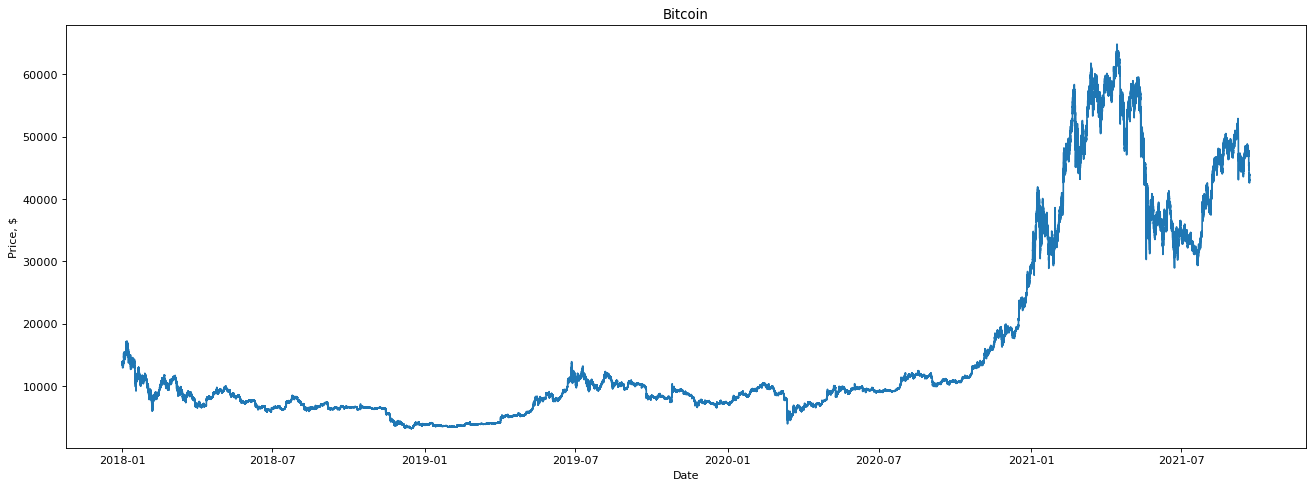

In [20]:
date = pd.to_datetime(btc.index,unit='s')
fig = plt.figure(figsize=(20,7), dpi=80)
plt.plot(date, btc['Close'].values)
plt.title('Bitcoin')
plt.xlabel('Date')
plt.ylabel('Price, $')

- Then check the `Open` over time

Text(0, 0.5, 'Price, $')

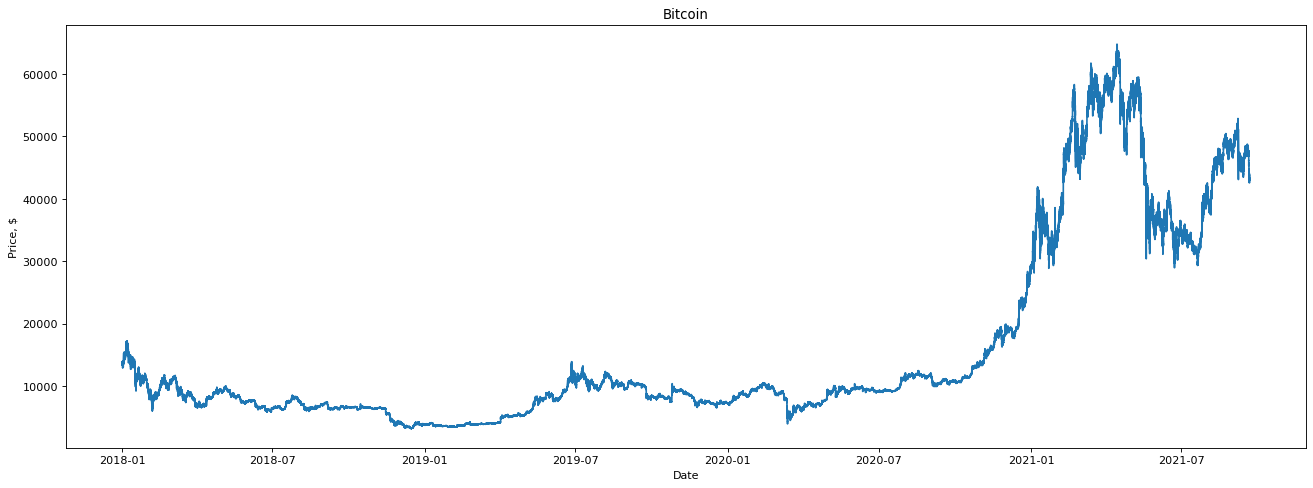

In [21]:
date = pd.to_datetime(btc.index,unit='s')
fig = plt.figure(figsize=(20,7), dpi=80)
plt.plot(date, btc['Open'].values)
plt.title('Bitcoin')
plt.xlabel('Date')
plt.ylabel('Price, $')

- Another graph showing how the `Volume` of Bitcoin has changed over time.

Text(0, 0.5, 'Volume')

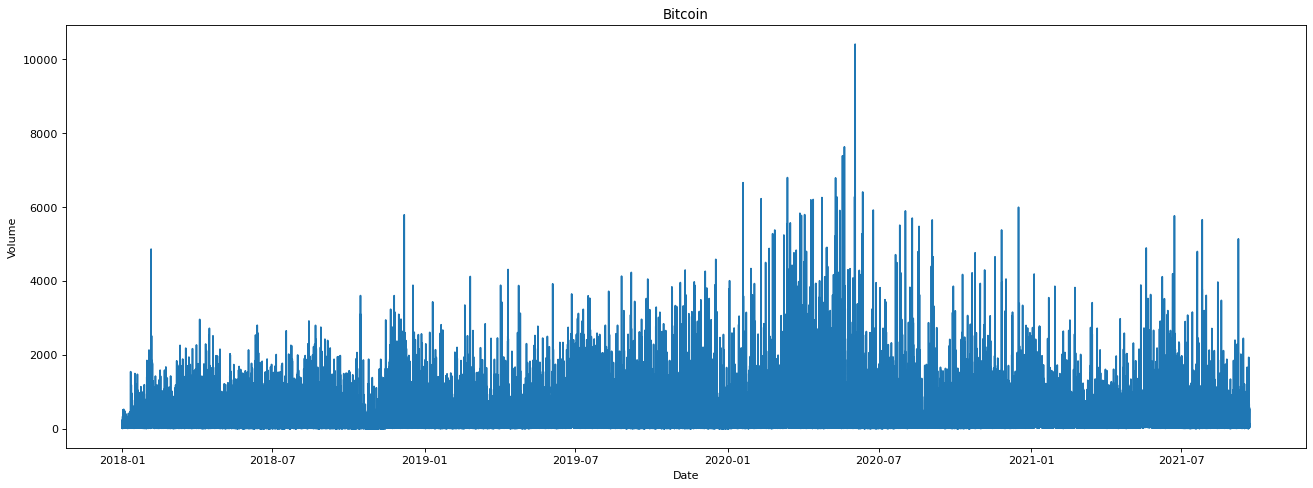

In [22]:
date = pd.to_datetime(btc.index,unit='s')
fig = plt.figure(figsize=(20,7), dpi=80)
plt.plot(date, btc['Volume'].values)
plt.title('Bitcoin')
plt.xlabel('Date')
plt.ylabel('Volume')

- Below graph shows the total number of trades over time. We can see the number of trades have been increased over time.

Text(0, 0.5, 'Count')

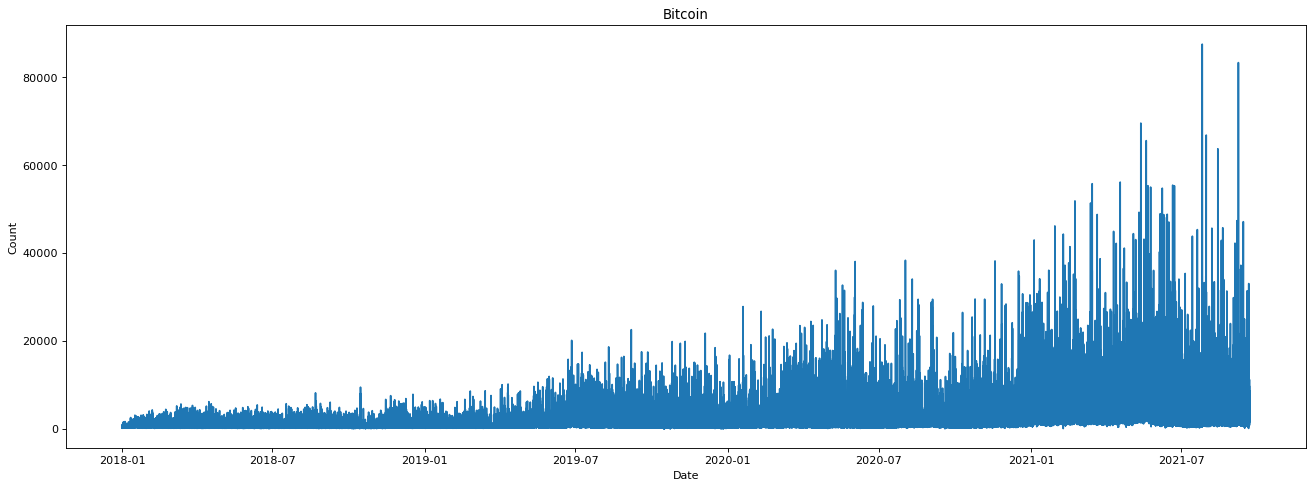

In [23]:
date = pd.to_datetime(btc.index,unit='s')
fig = plt.figure(figsize=(20,7), dpi=80)
plt.plot(date, btc['Count'].values)
plt.title('Bitcoin')
plt.xlabel('Date')
plt.ylabel('Count')

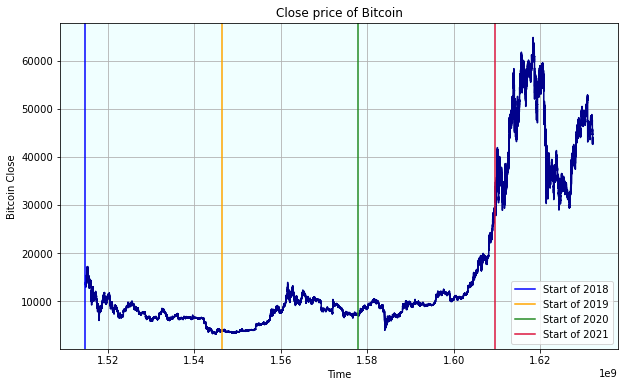

In [24]:
# find the yearwise transaction pattern
bitcoin1=bitcoin.set_index('timestamp')
f = plt.figure(figsize = (10,6))

ax = f.add_subplot(111)
ax.set_facecolor('azure')
plt.plot(bitcoin1['Close'], c = 'darkblue')
plt.axvline(x = 1514764860, label = 'Start of 2018', c = 'blue')
plt.axvline(x = 1546300860, label = 'Start of 2019', c = 'orange')
plt.axvline(x = 1577836860, label = 'Start of 2020', c = 'forestgreen')
plt.axvline(x = 1609459260, label = 'Start of 2021', c = 'crimson')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin Close')
plt.grid()
plt.title('Close price of Bitcoin')

plt.show()

We can easily see from the chart above that bitcoin had significant increasing in 2021, but in 2018 to 2020 it didn't have that much change, the price started to increase by the end of 2020.

## Descriptive statistics

In [25]:
bitcoin1.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,Count,Open,High,Low,Close,Volume,VWAP
count,1956960.00000,1956960.00000,1956960.00000,1956960.00000,1956960.00000,1956960.00000,1956960.00000
mean,1082.04475,15608.68223,15649.36142,15575.61440,15608.68257,92.82028,15608.56191
std,1601.67241,15119.57441,15130.20280,15104.42902,15119.60222,155.38791,15119.45477
min,1.00000,3149.65714,3176.91000,3120.00000,3151.54500,0.00010,3152.32587
25%,298.00000,6849.08799,6866.38500,6836.59250,6849.04446,30.18709,6849.11414
50%,563.00000,9204.97250,9221.20000,9190.26000,9204.93012,52.78533,9204.92734
75%,1259.00000,13459.61694,13516.34250,13393.46032,13460.30958,97.65168,13460.49157
max,87478.00000,64805.94375,64900.00000,64670.53000,64808.53728,10404.99537,64799.82221


- From descriptive statistics table above, we can see the price range has a significant different. Looking into `Close`, in the time frame from 2018 to 2021, the lowest price of bitcoin was 3151 but the higest price was 64808, we can easily see how volatite the bitcoin was in the past.
- The std of most of the variables have a pretty close value with the mean, only volume has a big differece. If the data points are further from the mean, there is a higher deviation within the data set; thus, the more spread out the data, the higher the standard deviation. We can conclude that Open, High, Low and Close values are really volitile but the volume of trading is pretty consistent compare to other components.

## 6. Build the model

- Since 2021 data has a big change compared to the rest of the dataset, We will split data to use data in 2021 to predict the price.

In [26]:
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%m/%d/%Y").timetuple()))
bitcoin21 = bitcoin.loc[totimestamp('01/01/2021'):totimestamp('09/21/2021'),]
bitcoin21 = bitcoin.set_index("timestamp")

In [27]:
bitcoin21.shape

(1956960, 7)

In [28]:
bitcoin21['datetime'] = pd.to_datetime(bitcoin21.index,unit='s')
bitcoin21_plot = bitcoin21.set_index('datetime')
bitcoin21.head()

,Count,Open,High,Low,Close,Volume,VWAP,datetime
timestamp,,,,,,,,
1514764860,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,2018-01-01 00:01:00
1514764920,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,2018-01-01 00:02:00
1514764980,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,2018-01-01 00:03:00
1514765040,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,2018-01-01 00:04:00
1514765100,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,2018-01-01 00:05:00


In [29]:
bitcoin21.tail()

,Count,Open,High,Low,Close,Volume,VWAP,datetime
timestamp,,,,,,,,
1632182160,1940.0,42983.780000,43001.850849,42878.26,42899.012857,56.850913,42935.489499,2021-09-20 23:56:00
1632182220,2026.0,42904.197143,42932.000000,42840.16,42860.005714,80.993326,42879.576084,2021-09-20 23:57:00
1632182280,1986.0,42859.385714,42887.500000,42797.20,42827.020000,65.677734,42844.090693,2021-09-20 23:58:00
1632182340,4047.0,42839.012802,43042.160000,42818.10,43017.277143,138.335477,42935.761938,2021-09-20 23:59:00
1632182400,2698.0,43009.961250,43048.510000,42961.64,43002.505000,128.206820,43011.414052,2021-09-21 00:00:00


In [30]:
#save the clean data to a csv file
#bitcoin21.to_csv("s3://msba-crypto-cats-east/sample-lstm/btc_2021.csv")

### Select Dates

- We split `80%` data points for training and `20%` for testing. Observation is recorded every 60 seconds, that means 60 times per hour. 

- We are tracking data from `2021` and `one month`. This data will be used to predict the price after 15 timestamps (150/10=15 minutes).

- to normalize data, We will take the `MinMaxScaler` preprocessing class from the scikit-learn library.

In [31]:
# directly load clean data for faster training

#df = pd.read_csv('s3://msba-crypto-cats-east/sample-lstm/btc_0628.csv') # whole dates

df = pd.read_csv("s3://msba-crypto-cats-east/sample-lstm/btc_2021.csv") #2021

df.head()

,datetime,timestamp,Count,Open,High,Low,Close,Volume,VWAP,datetime.1
0,2021-01-01 00:00:00,1609459200,2135.0,28950.497500,29024.59,28903.86,28948.192734,117.463121,28952.473085,2021-01-01 00:00:00
1,2021-01-01 00:01:00,1609459260,4039.0,28985.511250,29086.90,28960.00,29032.387500,163.787036,29017.664870,2021-01-01 00:01:00
2,2021-01-01 00:02:00,1609459320,1969.0,29031.175000,29079.56,28951.50,29002.956734,98.754670,29014.703526,2021-01-01 00:02:00
3,2021-01-01 00:03:00,1609459380,1689.0,29002.977509,29069.39,28967.80,29005.580000,55.202131,29003.078663,2021-01-01 00:03:00
4,2021-01-01 00:04:00,1609459440,1146.0,29004.293750,29057.73,28971.80,29000.490000,56.575903,29006.256629,2021-01-01 00:04:00


## Data of 2021

In [32]:
df.index=df['datetime'] 
df =df.loc['2021-01-01 00:01:00':'2021-09-21 00:00:00'] # 2021 data

In [33]:
df.head()

,datetime,timestamp,Count,Open,High,Low,Close,Volume,VWAP,datetime.1
datetime,,,,,,,,,,
2021-01-01 00:01:00,2021-01-01 00:01:00,1609459260,4039.0,28985.511250,29086.90,28960.0,29032.387500,163.787036,29017.664870,2021-01-01 00:01:00
2021-01-01 00:02:00,2021-01-01 00:02:00,1609459320,1969.0,29031.175000,29079.56,28951.5,29002.956734,98.754670,29014.703526,2021-01-01 00:02:00
2021-01-01 00:03:00,2021-01-01 00:03:00,1609459380,1689.0,29002.977509,29069.39,28967.8,29005.580000,55.202131,29003.078663,2021-01-01 00:03:00
2021-01-01 00:04:00,2021-01-01 00:04:00,1609459440,1146.0,29004.293750,29057.73,28971.8,29000.490000,56.575903,29006.256629,2021-01-01 00:04:00
2021-01-01 00:05:00,2021-01-01 00:05:00,1609459500,2088.0,28994.918934,29031.71,28929.3,28962.285818,70.319136,28972.005783,2021-01-01 00:05:00


### Multi-Feature

We create the model by splitting the data set with 80% of train data and 20% of test data, we use 3 features: `Count`, `Close` and `Volume`

In [46]:
num_shape = round(df.shape[0]*0.8)
window = 15
train = df.iloc[:num_shape, [2,6,7]].values
test = df.iloc[num_shape:, [2,6,7]].values
TestingRecords=len(df[num_shape:])

df_price = np.vstack((train, test)) #used to stack arrays in sequence vertically (row wise)
print("train shape:", train.shape)
print("test shape:", test.shape)
sc = MinMaxScaler(feature_range = (0, 1))
# Previous prices, price on next day, window
# Fit the scaler using available training data, then apply the scale to training data.
X_train, Y_train = [], []
train_scaled = sc.fit_transform(train)

for i in range(train.shape[0]-window):
    batch = train_scaled[i, :]
    X_train.append(batch)
    Y_train.append(train_scaled[i+window, 0])
X_train = np.stack(X_train)
Y_train = np.stack(Y_train)

X_test = []
Y_test = []
test_scaled = sc.fit_transform(df_price[num_shape-window:])

for i in range(test.shape[0]):
    batch = test_scaled[i, :]
    X_test.append(batch)
    Y_test.append(train_scaled[i+window, 0])
X_test = np.stack(X_test)
Y_test = np.stack(Y_test)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

train shape: (302976, 3)
test shape: (75744, 3)
X_train shape: (302961, 3)
X_test shape: (75744, 3)


- Apply the model

In [47]:
model = XGBRegressor()
model.fit(X_train, Y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [48]:
# prepare the proper shape for inverse_transform
t = np.zeros((len(Y_test),2))

# Getting the original price values for testing data
yt = np.c_[Y_test,t]
orig=sc.inverse_transform(yt)[:,0]

# Making predictions on test data
predicted_Price = model.predict(X_test)
yp = np.c_[predicted_Price,t]
predicted_Price=sc.inverse_transform(yp)[:,0]

# metrics of the predictions
d = predicted_Price - orig
mse_f = np.mean(d**2)
mae_f = np.mean(abs(d))
rmse_f = np.sqrt(mse_f)
print("Results by manual calculation:")
print("MAE:",mae_f)
print("MSE:", mse_f)
print("RMSE:", rmse_f)

Results by manual calculation:
MAE: 1519.62092776218
MSE: 7188982.242149973
RMSE: 2681.2277490265487


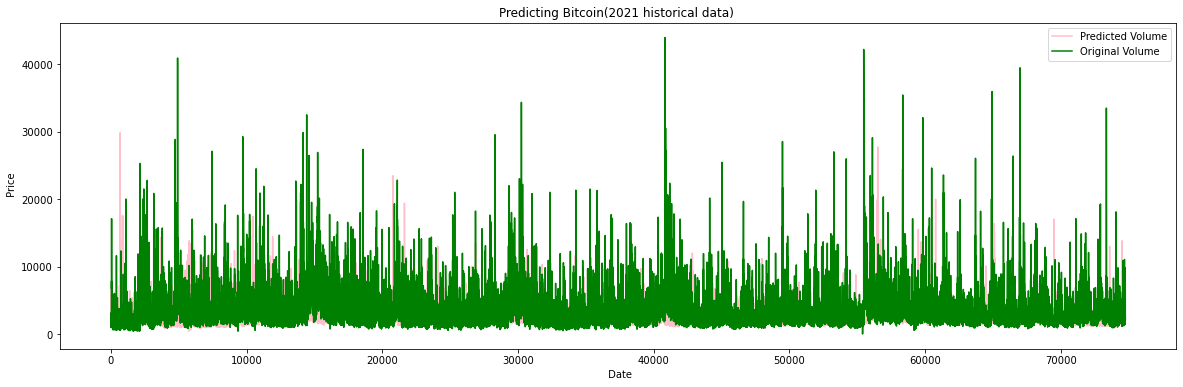

In [50]:
x1=predicted_Price[:-1000]
x2=orig[:-1000]
# Visualising the sampling results
plt.plot(x1, color = 'pink', label = 'Predicted Volume')
plt.plot(x2, color = 'green', label = 'Original Volume')
 
plt.title('Predicting Bitcoin(2021 historical data) ')
plt.xlabel(' Date')
plt.ylabel(' Price')
 
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

## Data of one month

In [51]:
df.index=df['datetime'] 
df1 =df.loc['2021-08-01 00:01:00':'2021-08-31 23:59:59'] # one month

In [52]:
df1.head()

,datetime,timestamp,Count,Open,High,Low,Close,Volume,VWAP,datetime.1
datetime,,,,,,,,,,
2021-08-01 00:01:00,2021-08-01 00:01:00,1627776060,6259.0,41444.920000,41478.50,41256.309885,41295.751429,190.192685,41350.109262,2021-08-01 00:01:00
2021-08-01 00:02:00,2021-08-01 00:02:00,1627776120,11909.0,41292.327143,41345.60,41105.000000,41169.534286,638.870283,41208.024665,2021-08-01 00:02:00
2021-08-01 00:03:00,2021-08-01 00:03:00,1627776180,5532.0,41165.252500,41325.73,41131.000000,41272.851250,441.032651,41224.606365,2021-08-01 00:03:00
2021-08-01 00:04:00,2021-08-01 00:04:00,1627776240,3551.0,41301.122857,41383.10,41277.740000,41358.837143,223.527657,41332.179987,2021-08-01 00:04:00
2021-08-01 00:05:00,2021-08-01 00:05:00,1627776300,6635.0,41362.957143,41569.38,41339.990000,41526.921429,502.113670,41451.623090,2021-08-01 00:05:00


In [53]:
num_shape1 = round(df1.shape[0]*0.8)
window = 15
train1 = df1.iloc[:num_shape1, [2,6,7]].values
test1 = df1.iloc[num_shape1:, [2,6,7]].values
TestingRecords=len(df1[num_shape1:])

df1_price = np.vstack((train1, test1))
print("train1 shape:", train1.shape)
print("test1 shape:", test1.shape)
sc = MinMaxScaler(feature_range = (0, 1))
# Previous prices, price on next day, window
X_train1, Y_train1 = [], []
train_scaled1 = sc.fit_transform(train1)

for i in range(train1.shape[0]-window):
    batch = train_scaled1[i, :]
    X_train1.append(batch)
    Y_train1.append(train_scaled1[i+window, 0])
X_train1 = np.stack(X_train1)
Y_train1 = np.stack(Y_train1)

X_test1 = []
Y_test1 = []
test_scaled1 = sc.fit_transform(df1_price[num_shape1-window:])

for i in range(test1.shape[0]):
    batch = test_scaled1[i, :]
    X_test1.append(batch)
    Y_test1.append(train_scaled1[i+window, 0])
X_test1 = np.stack(X_test1)
Y_test1 = np.stack(Y_test1)
print("X_train1 shape:", X_train1.shape)
print("X_test1 shape:", X_test1.shape)

train1 shape: (35711, 3)
test1 shape: (8928, 3)
X_train1 shape: (35696, 3)
X_test1 shape: (8928, 3)


In [ ]:
model1 = XGBRegressor(n_estimators=1000)
model1.fit(X_train1, Y_train1, verbose=False)

In [55]:
# prepare the proper shape for inverse_transform
t = np.zeros((len(Y_test1),2))

# Getting the original price values for testing data
yt = np.c_[Y_test1,t]
orig1=sc.inverse_transform(yt)[:,0]

# Making predictions on test data
predicted_Price1 = model1.predict(X_test1)
yp = np.c_[predicted_Price1,t]
predicted_Price1=sc.inverse_transform(yp)[:,0]

# metrics of the predictions
d = predicted_Price1 - orig1
mse_f = np.mean(d**2)
mae_f = np.mean(abs(d))
rmse_f = np.sqrt(mse_f)
print("Results by manual calculation:")
print("MAE:",mae_f)
print("MSE:", mse_f)
print("RMSE:", rmse_f)

Results by manual calculation:
MAE: 516.1102363618749
MSE: 721361.016670949
RMSE: 849.3297455470101


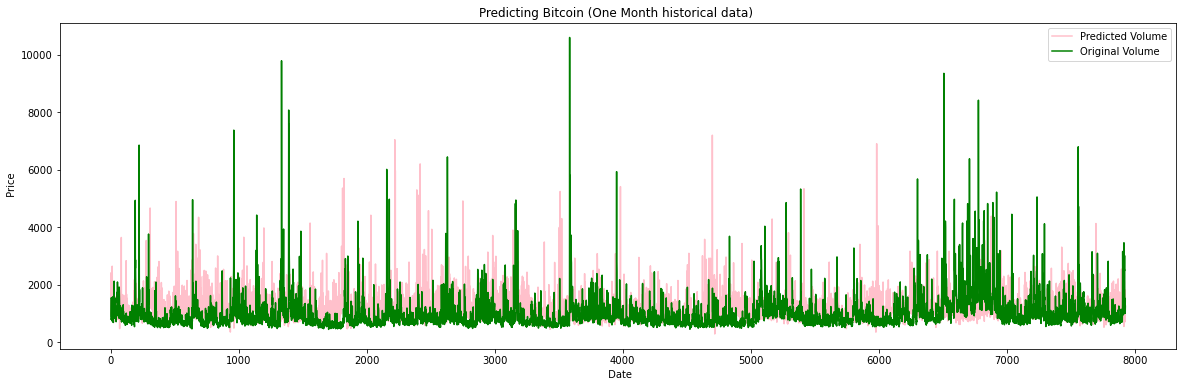

In [56]:
x1=predicted_Price1[:-1000]
x2=orig1[:-1000]
# Visualising the sampling results
plt.plot(x1, color = 'pink', label = 'Predicted Volume')
plt.plot(x2, color = 'green', label = 'Original Volume')
 
plt.title('Predicting Bitcoin (One Month historical data) ')
plt.xlabel(' Date')
plt.ylabel(' Price')
 
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

- MSE (Mean Squared Error) represents the difference between the original and predicted values which are extracted by squaring the average difference over the data set. It is a measure of how close a fitted line is to actual data points. The lesser the Mean Squared Error, the closer the fit is to the data set. 
- We got a high MSE when using whole historical data in 2021 while MSE is lower when using historical data in one month, this case we used data in august 2021. Thus, we should use data of one month to have a better prediction of the Bitcoin's price. 
- Next step we will try other different models to find the model with best MSE to decide which model is the best for Bitcoin's prediction.

Approaches                         | Best Test MSE         | 
-----------------------------------|-----------------------|
Multi-features (2021)              | 7188982.24            |                    
**Multi-features (one month)**     | **721361.01**         |                          